# The HANDY model
"Human And Nature DYnamics" is a rather simple model that can be used to study the behaviour of societies or civilizations. It extends upon the well-known predator-prey model by introducing the concepts of accumulated wealth and social stratification. 

Essentially, HANDY describes the competition between humans and nature. Humans can accumulate wealth (essentially 'store food') that will enable them to prosper for some time even if nature is depleted beyond recovery. The population is split in commoners and elites. Commoners do the most fundamental work, i.e. deplete nature to get food for themselves and the elites). Elites could be thought of as managers, elderly, scientists, etc; they do not directly affect nature, but thrive on the wealth accumulated by commoners. Within the model, inequality can be introduced by having elites earn more money (i.e. consume more) than the workers. In that case, if nature is depleted, famine starts to affect the commoners before it reaches the elites.

The model was introduced in a very [well-written paper](http://www.sciencedirect.com/science/article/pii/S0921800914000615) that also received a lot of attention. Journalists claimed that it predicted the collapse of the current society and critical reviews ([like this one](https://www.wsws.org/en/articles/2014/11/01/hand-n01.html)) accused it of oversimplifying reality. The authors' response to this critisim can be found [here](https://www.elsevier.com/connect/q-and-a-when-a-theoretical-article-is-misinterpreted). 

Regardless of the societal impact of the publication, this model is a very nice toy model and implementing it is a nice exercise. Here I present my implementation of the model in Python and try to reproduce the results of the paper. First, I used scipy's `odeint` solver for the numerical integration. Interestingly, scipy used the lotka-volterra model as [an example](http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html) to use this solver. However, this algorithm became unstable for several simulations, probably due to nature becoming negative etc. Using scipy's `ode` instead works fine, regardsless of the solver. However, to reproduce the collapses in the paper, I needed to downgrade to a simple euler scheme.

Without further due, I will now present the code and proceed with the solutions. I will not bother to describe the model in detail, since this is already very-well explained in the original paper.

In [337]:
def handy(
    # Prognostic variables & time
    x_C     = 100.,          # Commoner population
    x_E     = 25.,           # Elite population
    y       = 100.,          # Nature
    w       = 0.,            # Accumulated wealth
    # Model constants
    alpha_m = 0.01,         # Normal (minimum) death rate
    alpha_M = 0.07,         # Famine (maximum) death rate
    beta_C  = 0.03,         # Commoner birth rate
    beta_E  = 0.03,         # Elite birth rate
    s       = 0.0005,       # Subsistence salary per capita
    rho     = 0.005,        # Threshold wealth per capita
    gamma   = 0.01,         # Regeneration rate of nature
    labda   = 100.,         # Nature carrying capacity (lambda not possible)
    kappa   = 10.,          # Inequality factor (1,10,100)
    delta   = 0.00000833,   # Depletion (production) factor
    # Extra options
    verbose = True,         # Print diagnostic output of the simulation
    ):
    ''' Integrate a society to the next era '''
    
    from scipy.integrate import ode
    import numpy as np

    def tendency(time,society):
        ''' Compute the overall tendency for each prognostic variable '''
        # Parse input for readability and to prevent negative values sneeking in
        x_C = society[0]
        x_E = society[1]
        y   = society[2]
        w   = society[3]       

        # Compute diagnostic (time-dependent) variables:
        w_th = rho*(x_C+kappa*x_E)              # Threshold wealth
        omega = w/w_th if not w_th==0 else 0    # Normalized wealth
        c_C = min(1,omega)*s*x_C                # Commoner consumption
        c_E = min(1,omega)*s*x_E*kappa          # Elite consumption
        alpha_C = alpha_m+max(0,1-c_C/(s*x_C))*(alpha_M-alpha_m) if not x_C==0 else alpha_M
        alpha_E = alpha_m+max(0,1-c_E/(s*x_E))*(alpha_M-alpha_m) if not x_E==0 else alpha_M

        return [
                beta_C*x_C - alpha_C*x_C, # Commoners tendency
                beta_E*x_E - alpha_E*x_E, # Elites tendency
                max(-y,gamma*y*(labda-y)-delta*x_C*y), # Nature tendency, prevent from becoming negative
                delta*x_C*y-c_C-c_E # Wealth tendency
                ]

    # Do the actual time stepping
    society = np.asarray([x_C,x_E,y,w]) # Scipy prefers the state of my society as a list

    # Using SCIPY ode-solver
    solv = ode(tendency)
    solv.set_integrator('vode',method='bdf')
    solv.set_integrator('lsoda')
    solv.set_initial_value(society,0.)
    ys = []
    while solv.successful() and solv.t<1500.:
        solv.integrate(solv.t+1.)
        ys.append(solv.y)
    solution = np.vstack(ys).T
    
    # Euler forward integration reproduces the collapse mechanism!!!
#     ys = []
#     for t in range(1000):
#         society = society + np.asarray(tendency(t,society))
#         ys.append(society)
#     solution = np.vstack(ys).T


    if verbose:
        #####################################################
        # Some additional output for better interpretation ##
        # Determine the type of society
        if x_E==0:
            soc_type = 'egalitarian'
            soc_descr = 'no elites, only workers around'
        elif kappa==1:
            soc_type = 'equitable'
            soc_descr = "no inequality, but elites don't work"
        else:
            soc_type = 'unequal'
            soc_descr = 'elites present and richer than workers'
        print "This is an %s society (%s)"%(soc_type,soc_descr)

        # Determine the ratio of elites/workers
        if not soc_type=='unequal':
            psi = x_E/x_C
        else:
            psi = solution[1,-1]/solution[0,-1]

        # Determine whether an equilibrium is possible
        eta = (alpha_M-beta_C)/(alpha_M-alpha_m) # Helpful dimensionless parameter
        condition3 = abs((alpha_M-beta_E)/(kappa*(alpha_M-alpha_m))-eta) < 0.0001
        if not alpha_m<=beta_E<=beta_C<=alpha_M:
            print "No equilibrium is possible for this society"
        elif soc_type=='unequal' and not condition3:
            print "No equilibrium is possible for this society"
        else: # equilibrium possible
            workers = gamma/delta*(labda-eta*s/delta*(1+kappa*psi))
            elites = psi*workers
            nature = eta*s/delta*(1+kappa*psi)
            wealth = eta*rho*(1+kappa*psi)*workers
            chi = workers+elites
            delta_opt = 2*eta*s/labda*(1+kappa*psi)
            chi_M = gamma/(eta*s)*(labda/2.)**2*(1+psi)/(1+kappa*psi)

            print "A theoretical equilibrium for this society is:"
            print "    Commoners: %.f"%workers
            print "    Elites: %.f"%elites
            print "    Nature: %.f"%nature
            print "    Wealth: %.f"%wealth
            print "Its carrying capacity is %.f"%chi
            print "Maximum carrying capacity would be %.f"%chi_M
            print "... attained at depletion rate %.3e"%delta_opt

    return solution

In [314]:
%matplotlib inline
def visualize(solution):
    
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA
    import matplotlib.pyplot as plt

    ax1 = host_subplot(111,axes_class=AA.Axes)
    ax2 = ax1.twinx(); ax2.axis["right"].set_visible(False)
    ax3 = ax1.twinx() # this one we do want on the default right side
    ax4 = ax1.twinx(); ax2.axis["right"].set_visible(False)
         
#     par.axis["side"].label.set_visible(True)
#     par.axis["side"].set_label(PYlabel)
    
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["left"] = new_fixed_axis(loc="left",axes=ax2,offset=(-60,0))
    ax2.axis["left"].toggle(all=True)
    new_fixed_axis = ax4.get_grid_helper().new_fixed_axis
    ax4.axis["right"] = new_fixed_axis(loc="right",axes=ax4,offset=(60,0))
    ax4.axis["right"].toggle(all=True)
    
    p1, = ax1.plot(solution[0],label='Commoners',color='#1f77b4')
    p2, = ax2.plot(solution[1],label='Elites',color='#ff7f0e')
    p3, = ax3.plot(solution[2],label='Nature',color='#2ca02c')
    p4, = ax4.plot(solution[3],label='Wealth',color='#d62728')

    ax1.set_ylabel('Commoners')
    ax2.set_ylabel('Elites')
    ax3.set_ylabel('Nature')
    ax4.set_ylabel('Wealth')
    
    ax1.axis["left"].label.set_color(p1.get_color())
    ax2.axis["left"].label.set_color(p2.get_color())
    ax3.axis["right"].label.set_color(p3.get_color())
    ax4.axis["right"].label.set_color(p4.get_color())
    
    plt.show()

I will name the figures after their respective section is the original manuscript

# 5.1 Egalitarian societies (no elites)
## 5.1.1 Optimal depletion rate: soft landing to optimal equilibrium

This is an egalitarian society (no elites, only workers around)
A theoretical equilibrium for this society is:
    Commoners: 75000
    Elites: 0
    Nature: 50
    Wealth: 250
Its carrying capacity is 75000
Maximum carrying capacity would be 75000
... attained at depletion rate 6.667e-06


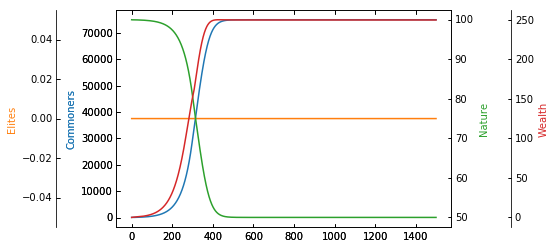

In [315]:
solution = handy(x_E=0.,delta=6.67e-6)
visualize(solution)

## 5.1.2 Oscillatory approach to equilibrium

This is an egalitarian society (no elites, only workers around)
A theoretical equilibrium for this society is:
    Commoners: 47928
    Elites: 0
    Nature: 20
    Wealth: 160
Its carrying capacity is 47928
Maximum carrying capacity would be 75000
... attained at depletion rate 6.667e-06


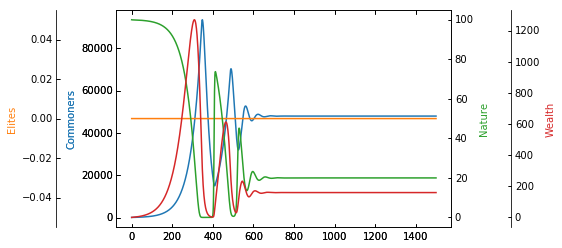

In [316]:
solution = handy(x_E=0.,delta=1.67e-5)
visualize(solution)

## 5.1.3 Cycles of prosperity, overshoot, collapse and revival

This is an egalitarian society (no elites, only workers around)
A theoretical equilibrium for this society is:
    Commoners: 32777
    Elites: 0
    Nature: 12
    Wealth: 109
Its carrying capacity is 32777
Maximum carrying capacity would be 75000
... attained at depletion rate 6.667e-06


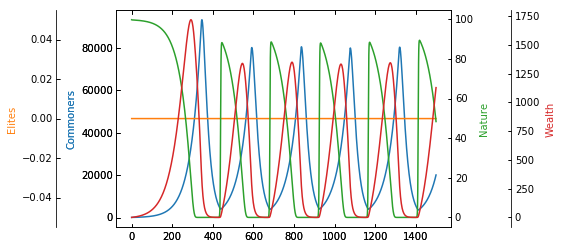

In [317]:
solution = handy(x_E=0.,delta=2.67e-5)
visualize(solution)

## 5.1.4 Irreversible Type-N collapse (not reproduced)

This is an egalitarian society (no elites, only workers around)
A theoretical equilibrium for this society is:
    Commoners: 24773
    Elites: 0
    Nature: 9
    Wealth: 83
Its carrying capacity is 24773
Maximum carrying capacity would be 75000
... attained at depletion rate 6.667e-06


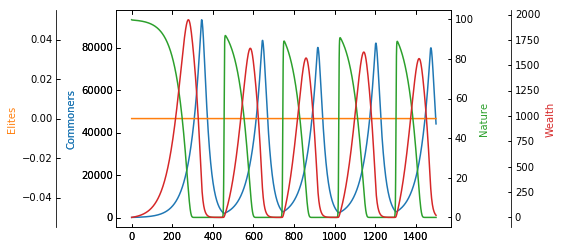

In [318]:
solution = handy(x_E=0.,delta=3.67e-5)
visualize(solution)

# 5.2 Equitable societies

## 5.2.1 Soft landing to optimal equilibrium

This is an equitable society (no inequality, but elites don't work)
A theoretical equilibrium for this society is:
    Commoners: 60000
    Elites: 15000
    Nature: 50
    Wealth: 250
Its carrying capacity is 75000
Maximum carrying capacity would be 75000
... attained at depletion rate 8.333e-06


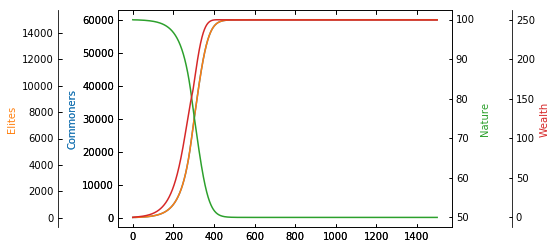

In [319]:
solution = handy(x_E=25.,kappa=1,delta=8.33e-6)
visualize(solution)

## 5.2.2 Oscillatory approach to equilibrium

This is an equitable society (no inequality, but elites don't work)
A theoretical equilibrium for this society is:
    Commoners: 36846
    Elites: 9211
    Nature: 19
    Wealth: 154
Its carrying capacity is 46057
Maximum carrying capacity would be 75000
... attained at depletion rate 8.333e-06


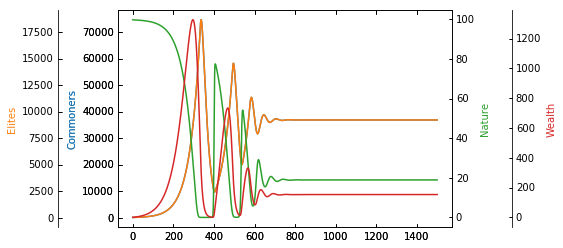

In [320]:
solution = handy(x_E=25.,kappa=1,delta=2.2e-5)
visualize(solution)

## 5.2.3 Cylces of prosperity, overshoot, collapse and revival

This is an equitable society (no inequality, but elites don't work)
A theoretical equilibrium for this society is:
    Commoners: 28704
    Elites: 7176
    Nature: 14
    Wealth: 120
Its carrying capacity is 35880
Maximum carrying capacity would be 75000
... attained at depletion rate 8.333e-06


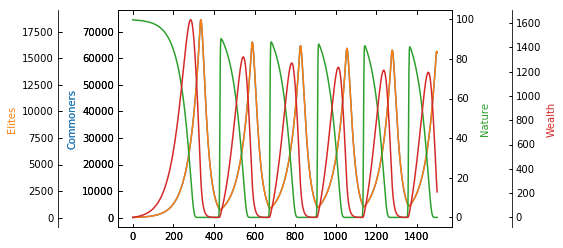

In [321]:
solution = handy(x_E=25.,kappa=1,delta=3.0e-5)
visualize(solution)

## 5.2.4 Full collapse (not reproduced)

This is an equitable society (no inequality, but elites don't work)
A theoretical equilibrium for this society is:
    Commoners: 20872
    Elites: 5218
    Nature: 10
    Wealth: 87
Its carrying capacity is 26090
Maximum carrying capacity would be 75000
... attained at depletion rate 8.333e-06


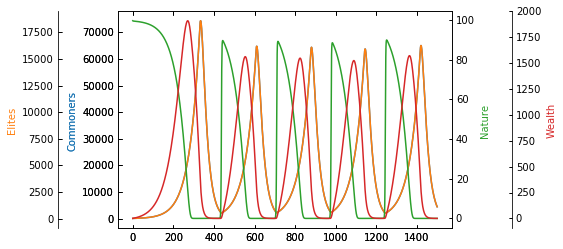

In [322]:
solution = handy(x_E=25.,kappa=1,delta=4.33e-5)
visualize(solution)

## 5.2.5 Preventing full collapse by decreasing average depletion per capita (less workers)

This is an equitable society (no inequality, but elites don't work)
A theoretical equilibrium for this society is:
    Commoners: 10650
    Elites: 63897
    Nature: 54
    Wealth: 248
Its carrying capacity is 74547
Maximum carrying capacity would be 75000
... attained at depletion rate 4.667e-05


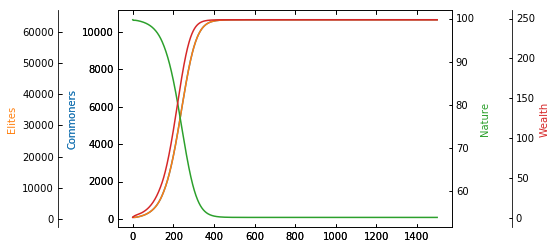

In [323]:
solution = handy(x_E=600.,kappa=1.,delta=4.33e-5)
visualize(solution)

# 5.3 Unequal societies

## 5.3.1 Type-L collapse

This is an unequal society (elites present and richer than workers)
No equilibrium is possible for this society


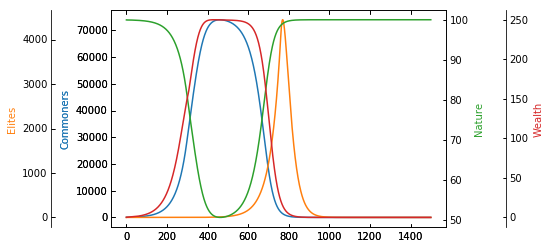

In [324]:
solution = handy(x_E=0.001,kappa=100.,delta=6.67e-6)
visualize(solution)

## 5.3.2 Type-N collapse (paper cut-off at t=500, but our simulations last longer)

This is an unequal society (elites present and richer than workers)
No equilibrium is possible for this society


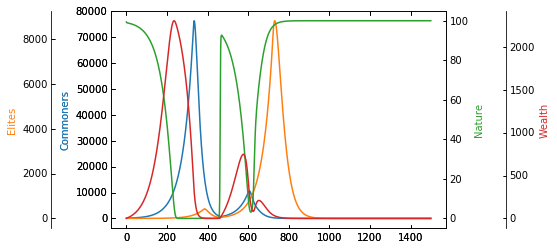

In [325]:
solution = handy(x_E=0.20,kappa=100.,delta=1.0e-4)
visualize(solution)

## 5.3.3 Soft landing

This is an unequal society (elites present and richer than workers)
A theoretical equilibrium for this society is:
    Commoners: 79088
    Elites: 52090
    Nature: 50
    Wealth: 250
Its carrying capacity is 131178
Maximum carrying capacity would be 131181
... attained at depletion rate 6.322e-06


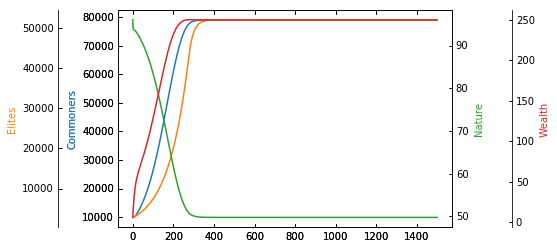

In [326]:
solution = handy(beta_C=6.5e-2,beta_E=2.0e-2,x_C=1.0e4,x_E=3.0e3,kappa=10.,delta=6.35e-6)
visualize(solution)

## 5.3.4 Oscillatory approach

This is an unequal society (elites present and richer than workers)
A theoretical equilibrium for this society is:
    Commoners: 73490
    Elites: 2883
    Nature: 4
    Wealth: 43
Its carrying capacity is 76373
Maximum carrying capacity would be 447857
... attained at depletion rate 1.160e-06


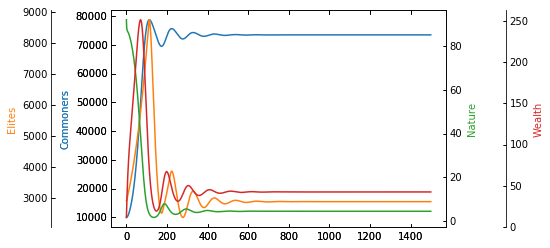

In [327]:
solution = handy(beta_C=6.5e-2,beta_E=2.0e-2,x_C=1.0e4,x_E=3.0e3,kappa=10.,delta=1.3e-5)
visualize(solution)

# Discussion
I was not able to reproduce all of the events as presented in the paper, particularly N-type collapses. Using a simple Euler scheme (like the authors) allowed me to reproduce them, but distorted some other results. This suggests that some of the irreversible collapses are actually artefacts of the numerical implementation. Testing with single precision (like the authors) is unfortunately not easily done with python.

In [340]:
import numpy as np
import matplotlib.pyplot as plt

In [366]:
deltas = [0.0001,0.00001,0.000001,0.0000001]
kappas = [0.1,1,2,5,10,20,50,100,200,500,1000]
data = np.zeros((len(deltas),len(kappas)))

for i,delta in enumerate(deltas):
    for j,kappa in enumerate(kappas):
        solution = handy(beta_C=6.5e-2,beta_E=2.0e-2,x_C=1.0e4,x_E=3.0e3,kappa=kappa,delta=delta,verbose=False)
        data[i,j] = solution[0,-1]+solution[1,-1]

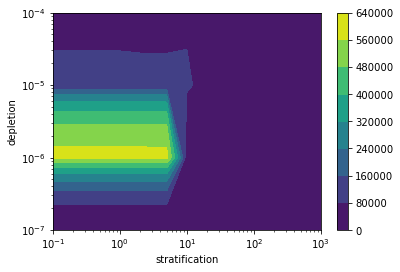

In [367]:
fig,ax = plt.subplots()
plt.contourf(kappas,deltas,data)
plt.xlabel('stratification')
plt.ylabel('depletion')
plt.xticks(kappas)
plt.yticks(deltas)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.colorbar()